<a href="https://colab.research.google.com/github/Vivekchavda1374/ML/blob/main/Final_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=31f8b01a72e159b3e80c71ee52d181bf75e2a0c039315855501f46e738b164e0
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyswarm import pso  # For PSO Optimization
import random

In [3]:
# 1. Loading the dataset
data = pd.read_csv('/content/Sentiment.csv')

In [4]:
# 2. Data Preprocessing
# Text cleaning function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = text.lower().strip()  # Convert to lowercase and strip extra spaces
    return text

In [5]:
print(data.columns)


Index(['Sentiment', 'Text'], dtype='object')


In [6]:
print(data.head())


   Sentiment                                               Text
0          0  Starting  back at work today   Looks like it'l...
1          1  Sugar levels dropping... munchies setting in. ...
2          1     @karineb22 yeah!!! have a great summer break! 
3          1  hannah montana was very good.  now going to re...
4          1  @Mayra326 aww, have fun!  I just had my 3D las...


In [7]:
# Apply text cleaning to the dataset
data['Cleaned_Text'] = data['Text'].apply(clean_text)

In [8]:
# Tokenization and Removing stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# Define function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [10]:
# Apply stopwords removal
data['Cleaned_Text'] = data['Cleaned_Text'].apply(remove_stopwords)

In [11]:
# 3. Splitting the dataset into training and testing sets
X = data['Cleaned_Text']
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 4. Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)

In [13]:
# 5. SVM Model pipeline
svm_model = make_pipeline(vectorizer, SVC(kernel='linear'))

In [14]:
# Train the SVM classifier
svm_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('svc', SVC(kernel='linear'))])

In [15]:
# Predict using SVM
y_pred_svm = svm_model.predict(X_test)

In [16]:
# SVM Model Evaluation
print("SVM Model Accuracy: ", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Model Accuracy:  0.7661432809947661
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     14963
           1       0.75      0.79      0.77     15034

    accuracy                           0.77     29997
   macro avg       0.77      0.77      0.77     29997
weighted avg       0.77      0.77      0.77     29997



In [ ]:

# 7. PSO for hyperparameter tuning of SVM
# Objective function for PSO
def evaluate_svm(params):
    C, gamma = params
    model = make_pipeline(TfidfVectorizer(), SVC(C=C, gamma=gamma, kernel='linear'))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -accuracy_score(y_test, y_pred)  # Negative because PSO minimizes the function

# Define bounds for C and gamma
lb = [0.1, 0.01]  # Lower bounds for C and gamma
ub = [100, 1]     # Upper bounds for C and gamma

# Run PSO optimization to find the best C and gamma
best_params, best_score = pso(evaluate_svm, lb, ub, swarmsize=10, maxiter=20)

print(f"Best parameters found using PSO: C={best_params[0]}, gamma={best_params[1]}")
print(f"Best score from PSO: {best_score}")

In [17]:
import numpy as np
import random

class AntColony:
    def __init__(self, n_ants, n_best, n_iteration, decay, alpha=1, beta=1):
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iteration = n_iteration
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def optimize(self, objective_function, param_ranges):
        # Initialize pheromone levels
        n_params = len(param_ranges)
        pheromones = np.ones((n_params, len(param_ranges[0])))
        best_params = None
        best_score = float('-inf')

        for iteration in range(self.n_iteration):
            all_solutions = []

            for ant in range(self.n_ants):
                solution = []
                for i, param_range in enumerate(param_ranges):
                    probabilities = pheromones[i] ** self.alpha
                    probabilities /= probabilities.sum()
                    choice = np.random.choice(param_range, p=probabilities)
                    solution.append(choice)

                score = objective_function(solution)
                all_solutions.append((solution, score))

                if score > best_score:
                    best_score = score
                    best_params = solution

            # Sort solutions by score and update pheromones
            all_solutions.sort(key=lambda x: x[1], reverse=True)
            for i in range(n_params):
                pheromones[i] *= self.decay  # Decay pheromone
                for solution, score in all_solutions[:self.n_best]:
                    param_index = param_ranges[i].index(solution[i])
                    pheromones[i][param_index] += 1 / (1.0 + score)

        return best_params

# Example Objective Function
def evaluate_svm(params):
    # Assume params[0] is C and params[1] is gamma
    from sklearn import datasets
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score

    data = datasets.load_iris()
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3)

    model = SVC(C=params[0], gamma=params[1])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

# Parameter ranges for SVM hyperparameters
param_ranges = [
    [0.1, 1, 10, 100],    # Values for C
    [0.01, 0.1, 1, 10]    # Values for gamma
]

# Initialize the Ant Colony optimizer
aco = AntColony(n_ants=10, n_best=3, n_iteration=20, decay=0.95)

# Optimize and find the best parameters
best_aco_params = aco.optimize(evaluate_svm, param_ranges)
print(f"Best parameters found using ACO: {best_aco_params}")

Best parameters found using ACO: [10.0, 0.01]


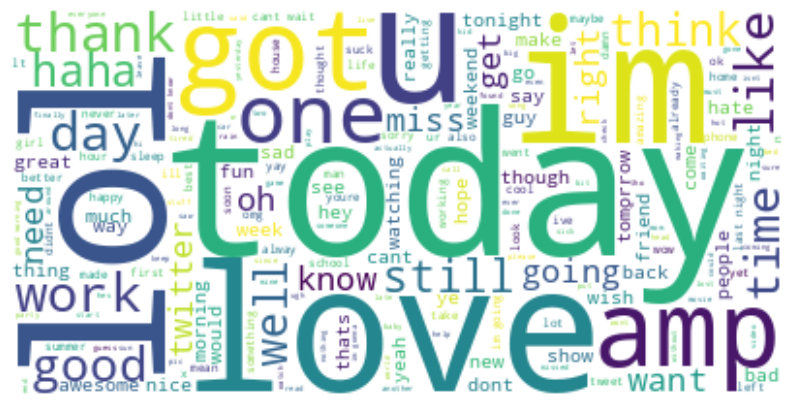

In [18]:
# 9. Visualization of most frequent words using WordCloud
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(' '.join(data['Cleaned_Text']))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
# 1. Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt_model = make_pipeline(vectorizer, DecisionTreeClassifier())
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.699036570323699
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     14963
           1       0.70      0.70      0.70     15034

    accuracy                           0.70     29997
   macro avg       0.70      0.70      0.70     29997
weighted avg       0.70      0.70      0.70     29997



In [20]:
# 2. Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = make_pipeline(vectorizer, RandomForestClassifier(n_estimators=100))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7532753275327533
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     14963
           1       0.76      0.75      0.75     15034

    accuracy                           0.75     29997
   macro avg       0.75      0.75      0.75     29997
weighted avg       0.75      0.75      0.75     29997



In [21]:
# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = make_pipeline(vectorizer, LogisticRegression())
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7673434010067673
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     14963
           1       0.76      0.79      0.77     15034

    accuracy                           0.77     29997
   macro avg       0.77      0.77      0.77     29997
weighted avg       0.77      0.77      0.77     29997



In [22]:
# 4. Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gb_model = make_pipeline(vectorizer, GradientBoostingClassifier())
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.6852018535186852
              precision    recall  f1-score   support

           0       0.80      0.50      0.61     14963
           1       0.64      0.87      0.74     15034

    accuracy                           0.69     29997
   macro avg       0.72      0.68      0.67     29997
weighted avg       0.72      0.69      0.67     29997



In [23]:
# 5. K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

knn_model = make_pipeline(vectorizer, KNeighborsClassifier(n_neighbors=5))
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.6106277294396106
              precision    recall  f1-score   support

           0       0.63      0.52      0.57     14963
           1       0.59      0.70      0.64     15034

    accuracy                           0.61     29997
   macro avg       0.61      0.61      0.61     29997
weighted avg       0.61      0.61      0.61     29997



In [24]:
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn

In [25]:
# 7. LightGBM Classifier
import lightgbm as lgb

lgb_model = make_pipeline(vectorizer, lgb.LGBMClassifier())
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59932, number of negative: 60056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.481392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173969
[LightGBM] [Info] Number of data points in the train set: 119988, number of used features: 4160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499483 -> initscore=-0.002067
[LightGBM] [Info] Start training from score -0.002067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Accuracy: 0.7459412607927459
              precision    recall  f1-score   support

           0       0.79      0.67      0.72     14963
           1       0.71      0.82      0.76     15034

    accuracy                           0.75     29997
   macro avg       0.75      0.75      0.74     29997
weighted avg       0.75      0.75      0.74     29997



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [26]:
# 8. Multi-Layer Perceptron (MLP) Neural Network
from sklearn.neural_network import MLPClassifier

mlp_model = make_pipeline(vectorizer, MLPClassifier(hidden_layer_sizes=(100,), max_iter=300))
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

print("MLP Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

MLP Neural Network Accuracy: 0.7386738673867387
              precision    recall  f1-score   support

           0       0.73      0.76      0.74     14963
           1       0.75      0.72      0.73     15034

    accuracy                           0.74     29997
   macro avg       0.74      0.74      0.74     29997
weighted avg       0.74      0.74      0.74     29997



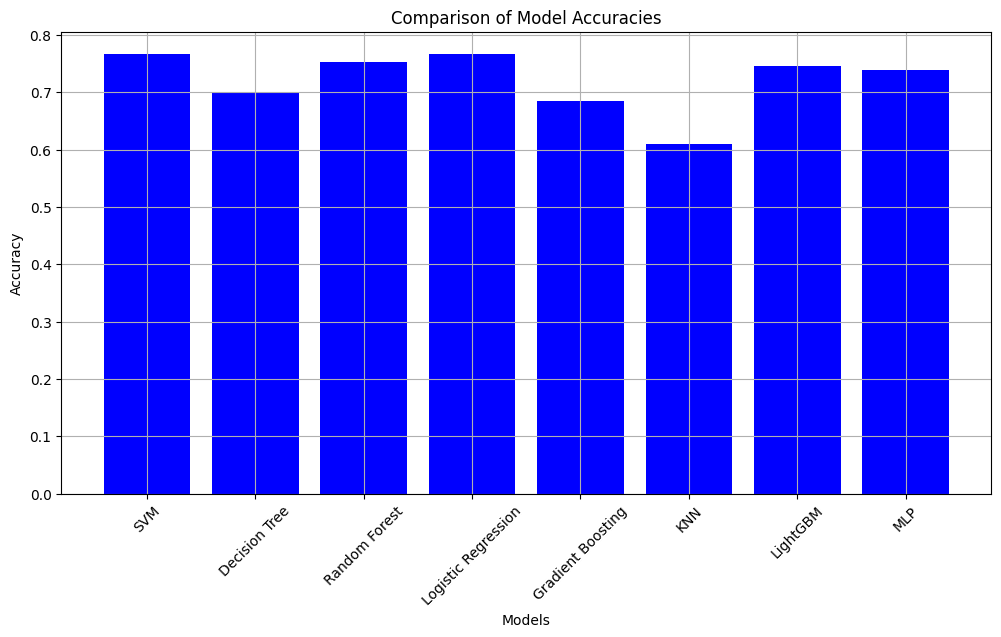

In [29]:
import matplotlib.pyplot as plt

models = ['SVM',  'Decision Tree', 'Random Forest', 'Logistic Regression',
          'Gradient Boosting', 'KNN', 'LightGBM', 'MLP']

accuracies = [accuracy_score(y_test, y_pred_svm),
              accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_gb),
              accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_lgb),
              accuracy_score(y_test, y_pred_mlp)]

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()